### Graham Kerr
#### graham.s.kerr@NASA.gov; kerrg@cua.edu

<H1 font size="+3" style="color:red">
RADYN --> RH<br>
-- Writes an RH15D (hdf5 format) atmosphere from RADYN ouput
</H1>

> - Reads the RADYN atmosphere
> - If desired, calculate non-thermal rates
> - If desired, perform refinement
> - Write the atmosphere



---
### <b style="color:blue"> Some set up </b>

***Import Modules***

In [121]:
##
## Import some modules
##

import sys
sys.path.insert(0,'/Users/gskerr1/Documents/Research/Python_Programs/radynpy/')
sys.path.insert(0,'/Users/gskerr1/Documents/Research/Python_Programs/pTau/src/')
import radynpy 
from radynpy.utils import RadynMovie as RM
from radynpy.utils import LineProfiles
from radynpy.utils.Utils import tradiation as tr
import pyTau

from helita.sim import rh15d 
from helita.vis import rh15d_vis
from scipy import constants 
import copy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import LogLocator
from matplotlib import ticker
import matplotlib.colorbar as cb
import pandas as pd

import cmocean
import colorcet as ccet
import palettable as pal 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

***Set up plot properties***

In [3]:
##
## Plot properties (these are just personal preference)
##

#Avenir LT Std
font = {'family': 'Avenir LT Std',
        'color':  'black',
        'weight': 'medium',
        'size': 22,
        }
plot_params = {'ytick.direction': 'in', 
               'xtick.direction': 'in', 
               'xtick.minor.visible': True,
               'ytick.minor.visible': True,
               'xtick.major.size': 10, 'xtick.minor.size': 5,
               'ytick.major.size': 10, 'ytick.minor.size': 5,
               'ytick.right': True,
               'xtick.top': True,
               'ytick.major.width': 1.5,
               'xtick.major.width': 1.5,
               'ytick.minor.width': 1.5,
               'xtick.minor.width': 1.5,
               'axes.linewidth': 1.5,
               'axes.spines.top': True,
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.titlepad' : 18 }

plot_lg_params = {'legend.frameon': False}
#plt.rcParams.update({'font.size': font['size'], 'font.family':font['family'], 'font.weight':font['weight'], 'font.color':font['color']})

plt.rcParams.update({'font.size':font['size'], 'font.family':font['family'], 'font.weight':font['weight']})
plt.rcParams.update({'ytick.direction': plot_params['ytick.direction'],
                     'xtick.direction': plot_params['xtick.direction'],
                     'xtick.minor.visible': plot_params['xtick.minor.visible'],
                     'ytick.minor.visible': plot_params['ytick.minor.visible'],
                     'ytick.major.size':  plot_params['ytick.major.size'], 
                     'ytick.minor.size':  plot_params['ytick.minor.size'],
                     'xtick.major.size':  plot_params['xtick.major.size'],                                
                     'xtick.minor.size':  plot_params['xtick.minor.size'],
                     'ytick.right': plot_params['ytick.right'],
                     'xtick.top': plot_params['xtick.top'],
                     'ytick.major.width': plot_params['ytick.major.width'],
                     'xtick.major.width': plot_params['xtick.major.width'],
                     'ytick.minor.width': plot_params['ytick.minor.width'],
                     'xtick.minor.width': plot_params['xtick.minor.width'],                    
                     'axes.linewidth': plot_params['axes.linewidth'],
                     'axes.spines.top' : plot_params['axes.spines.top'],
                     'axes.spines.bottom' : plot_params['axes.spines.bottom'],
                     'axes.spines.left' : plot_params['axes.spines.left'],
                     'axes.spines.right' : plot_params['axes.spines.right'],
                     'axes.titlepad' : plot_params['axes.titlepad'],
                    })

plt.rcParams.update({'legend.frameon': plot_lg_params['legend.frameon']})

mpl.mathtext.SHRINK_FACTOR = 0.6
mpl.mathtext.GROW_FACTOR = 1 / 0.6





template = dict(
        layout = go.Layout(font = dict(family = "Rockwell", size = 18),
                           title_font = dict(family = "Rockwell", size = 22), 
                           plot_bgcolor = 'white',
                           paper_bgcolor = 'white',
                           xaxis = dict(
                                showexponent = 'all',
                                exponentformat = 'e',
                                tickangle = 0,
                                linewidth = 4,
                                showgrid = True,
                            ),
                            yaxis = dict(
                          showexponent = 'all',
                          exponentformat = 'e',
                                linewidth = 4,
                                showgrid = True,
                                anchor = 'free',
                                position = 0,
                                domain = [0.0,1]
                            ),
                            coloraxis_colorbar = dict(
                                thickness = 15,
                                tickformat = '0.2f',
                                ticks = 'outside',
                                titleside = 'right'
                            )
                            ))

***Load the RADYN simulation***

In [4]:
## Load the cdf file
dir1 = '/Volumes/GrahamKerr/RADYN_sims_Stockholm/'
file1 = 'QSHTSL_1.00F10_d7_ec20_t30s_oneD_ne200_ext.cdf'
cdf = radynpy.cdf.LazyRadynData(dir1+file1)


In [364]:
## Extract the variables of interest
cdf.load_var('time') # time
cdf.load_var('z1') # height 
cdf.load_var('tg1') # temperature
cdf.load_var('ne1') # electron density
cdf.load_var('d1') # mass density
cdf.load_var('tau') # standard optical depth (500)
cdf.load_var('vz1') # velocity (positive = upflow)
cdf.load_var('n1') # population densities
cdf.load_var('title') # Sim ID
cdf.load_var('cc') # speed of light
cdf.load_var('nk') # number of levels in each species
cdf.load_var('atomid') # atom ID
cdf.load_var('ndep') # number of grid points
cdf.load_var('pg1')

In [15]:
cdf.title

'1.00F10, d7, ec20, t30                                                          '

---
### <b style="color:blue"> RH15D params </b>

***Some switches***

In [149]:
## Write helium non-thermal collisional rates, and select which atom size to model
include_hecnt = True
atom33 = False
atom9 = True
if atom33 == True:
    lev_Heigr = 0
    lev_Heiigr = 21
    lev_Heiiigr = 32
    nlevs_hecnt = 33
elif atom9 == True:
    lev_Heigr = 0
    lev_Heiigr = 5
    lev_Heiiigr = 8
    nlevs_hecnt = 9

## write populations for hydrogen, helium, calcium into seperate variables (for use with FIXED_POPS_FROM_FILE case)
include_hpops = True
include_hepops = True
include_capops = True

## refine grid using Jaime's pTau package
depth_refine = True

***Misc set up***

In [22]:
## Is there a B-field?
has_B = 0

## Boundary conditions 
## 0 = Zero; 1 = Thermalised; 2 = IRRADIATED; 3 = REFLECTIVE; 4 = IRRADIATED_INTP {only useable in G.Kerr's version} 
boundary_bottom = 1
boundary_top = 4 

## Sim ID
description = cdf.title

## Conversion to SI
cm_to_m=1.e-2


---
### <b style="color:blue"> Non-thermal rates </b>

> - If desired, calculate the non-thermal rates (currently just helium)

In [46]:
if include_hecnt == True:
   
    ## load the additional required variables
    cdf.load_var('fp_e')
    cdf.load_var('fp_f')
    cdf.load_var('fp_mu')
    mbeam = 511e3
    
    ## Extract some sizes and make an empty array to hold the electron flux
    nt = cdf.fp_f.shape[0]   
    ne = cdf.fp_f.shape[1]
    nmu = cdf.fp_f.shape[2]
    nz = cdf.fp_f.shape[3]
 
    ## Cell center the electron energy and pitch angle arrays and work out the factor required for phase vel. calc
    Em = 0.5*(cdf.fp_e[:,0:ne]+cdf.fp_e[:,1:ne+1])
    domega =  2.0 * constants.pi * (cdf.fp_mu[:,0:nmu] - cdf.fp_mu[:,1:nmu+1])
    gmam = Em/(mbeam/1e3) + 1
    btam = np.sqrt(1e0 - 1e0/gmam**2)
    
    ## Compute the number flux energy distribution electrons / cm^2 / s / keV
    flx = np.einsum('aijk,aj,ai->aik',cdf.fp_f[:,:,:,:],domega[:,:],btam[:,:])*cdf.cc
    
    
    ## Non-thermal collisional ionisation rate variables from AR85
        # ion energy
    Iohy = 13.60
    Iohei = 24.60
    Ioheii = 54.40
        # H I params
    Ahy = 22.80
    Bhy = -12.00
    Chy = 1.90
    Dhy = -22.60
        # He I params
    Ahei = 17.80
    Bhei = -11.00
    Chei = 7.00
    Dhei = -23.20
        # He II params
    Aheii = 14.40
    Bheii = -5.60
    Cheii = 1.90
    Dheii = -13.30
    
    ##
    ## Calculate the He I -> He II nonthermal rates
    ##
    Io = Iohei
    A = Ahei
    B = Bhei
    Co = Chei 
    D = Dhei
    cnt_hei = np.zeros([nt,nz],dtype=np.float64)
    for tind in range(0,nt):
        for eind in range(0,ne):
            Em_kev = (cdf.fp_e[tind,eind] + cdf.fp_e[tind,eind+1])*.5*1e3 #cell-centre value of E in eV
            u = Em_kev/Io
            dE = cdf.fp_e[tind,eind+1]-cdf.fp_e[tind,eind] ## keV
            Q = 1e-14*(A*(1.0-1.0/u) + B*(1.0-1.0/u)**2.0 + Co*np.log(u) + D*np.log(u)/u)/u/Io**2 ##cm^2
            cnt_hei[tind,:]+= flx[tind,eind,:]*Q*dE
            
    ##
    ## Calculate the He II -> He III nonthermal rates
    ##
    Io = Ioheii
    A = Aheii
    B = Bheii
    Co = Cheii 
    D = Dheii
    cnt_heii = np.zeros([nt,nz],dtype=np.float64)
    for tind in range(0,nt):
        for eind in range(0,ne):
            Em_kev = (cdf.fp_e[tind,eind] + cdf.fp_e[tind,eind+1])*.5*1e3 #cell-centre value of E in eV
            u = Em_kev/Io
            dE = cdf.fp_e[tind,eind+1]-cdf.fp_e[tind,eind] ## keV
            Q = 1e-14*(A*(1.0-1.0/u) + B*(1.0-1.0/u)**2.0 + Co*np.log(u) + D*np.log(u)/u)/u/Io**2 ##cm^2
            cnt_heii[tind,:]+= flx[tind,eind,:]*Q*dE   
        
    ##
    ## Assign the rates to the full array... we pass an array that holds all potential non-thermal rates,
    ## including excitation, all but ionisation are zero (for now). The assignment uses the convention in 
    ## RH that transition i --> j is stored in element ji of the array.
    ##
    helium_cnt = np.zeros([nt,nz,nlevs_hecnt*nlevs_hecnt], dtype = np.float)
        ## He I -> He II
    j = lev_Heiigr
    i = lev_Heigr
    ji = j*nlevs_hecnt+1
    helium_cnt[:,:,ji] = cnt_hei[:,:]
        ## He II -> He III
    j = lev_Heiiigr
    i = lev_Heiigr
    ji = j*nlevs_hecnt+1
    helium_cnt[:,:,ji] = cnt_heii[:,:]


---
### <b style="color:blue"> Extract the H, He, Ca populations </b>

> - Grab these here so they can be manipulated and written to the RH atmos file, if needed

In [92]:
ielh = np.where(cdf.atomid[0] == 'h   ')[0][0]
ielhe = np.where(cdf.atomid[0] == 'he  ')[0][0]
ielca = np.where(cdf.atomid[0] == 'ca  ')[0][0]

nlevh = cdf.nk[ielh]
nlevhe = cdf.nk[ielhe]
nlevca = cdf.nk[ielca]

hydrogen_populations = copy.deepcopy(cdf.n1[:,:,0:nlevh,ielh])
helium_populations = copy.deepcopy(cdf.n1[:,:,0:nlevhe,ielhe])
calcium_populations = copy.deepcopy(cdf.n1[:,:,0:nlevca,ielca])

---
### <b style="color:blue"> Perform depth refinement </b>

> - Refines the depth, if desired.
> - This evaluates gradients to determine the optimum spacing in depth for RT calcs
> - In particular, velocity gradients can be problematic if they exceed the doppler width of the line between cells
> - The first few params are hardcoded. Note that I am setting Tcut very large as I want to make sure not to miss any cold patches forming between temperature bubbles. Because of this I set ndep very much larger than the initial sim. 
> - Uses Jaime de la Cruz Rodriguez's tool: https://github.com/grahamkerr/pTau, itself based on MULTI_3D. The cell below is largely based on the example in Jaime's github repo, though we already have electron density and tau. The sourcecode (pTau.cpython*.so and pyTau.py) must be in the working directory, or in the path. 
> - Note that pTau needs an [x,y,z] box... to avoid a big rewrite I am just making a fake dimension for x, and so we have [dummy, time, height]

In [418]:
if depth_refine == True:
    
    ##
    ## Set up the parameters
    ## 
    nDep2    = 500     # Number of points in the new interpolated grid
    smooth   = 1       # smooth gradients with a top-hat PSF (should be smaller than 5)
    velscal  = 0.6     # scaling of velocity gradients in km/s (larger number gives less weight)
    Tcut     = 50e6    # Temperature cut off in the corona
    ltau_cut = 2    # Ma
    nthreads = 8       # Number of threads to use
    ntimes = len(cdf.time)
    nz = copy.deepcopy(cdf.ndep)

    
    ## 
    ## Create arrays with dummy variable then populate with the appropriate variable
    ##
    Tg = np.zeros([1,ntimes,nz], dtype = np.float64)
    rho = np.zeros([1,ntimes,nz], dtype = np.float64)
    vz = np.zeros([1,ntimes,nz], dtype = np.float64)
    ltau500 = np.zeros([1,ntimes,nz], dtype = np.float64)
    z = np.zeros([1,ntimes,nz], dtype = np.float64)
    Ne = np.zeros([1,ntimes,nz], dtype = np.float64)
    HPop = np.zeros([1,ntimes,nz,nlevh], dtype = np.float64)
    pgas = np.zeros([1,ntimes,nz],dtype=np.float64)

    Tg[0,:,:] = copy.deepcopy(cdf.tg1)
    rho[0,:,:] = copy.deepcopy(cdf.d1)
    vz[0,:,:] = copy.deepcopy(cdf.vz1)
    ltau500[0,:,:] = copy.deepcopy(np.log10(cdf.tau))
    ltau500[0,:,0] = -20
#     ltau500[0,:,0] = copy.deepcopy(ltau500[0,:,1])
    z[0,:,:] = copy.deepcopy(cdf.z1)
    Ne[0,:,:] = copy.deepcopy(cdf.ne1)
    HPop[0,:,:,:] = copy.deepcopy(hydrogen_populations)
    pgas[0,:,:] = copy.deepcopy(cdf.pg1)
    if include_capops == True:
        CaPop = np.zeros([1,ntimes,nz,nlevca], dtype = np.float64)
        CaPop[0,:,:,:] = copy.deepcopy(calcium_populations)
    if include_hepops == True:
        HePop = np.zeros([1,ntimes,nz,nlevhe], dtype = np.float64)
        HePop[0,:,:,:] = copy.deepcopy(helium_populations)
    if include_hecnt == True:
        HeCnt = np.zeros([1,ntimes,nz,nlevs_hecnt*nlevs_hecnt],dtype=np.float64)
        HeCnt[0,:,:,:] = copy.deepcopy(helium_cnt)

#     ltau500_tmp = pyTau.getTau(Tg, z, Pg=pgas, nthreads=nthreads, wav = [5000.0])
#     ltau500[0,:,:] = ltau500_tmp

    ##
    ## Evaluate the optimized scale 
    ##
    idx = pyTau.getOptimizedScale(Tg, rho, vz, ltau500, nDep2=nDep2, Tcut=Tcut,
                                  ltau_cut=ltau_cut, smooth_window=smooth,
                                  vel_scal=velscal, nthreads=nthreads)
    ##
    ## Interpolate the variables to this new scale
    ##
    z_new    = pyTau.OptimizeVariable(idx, z, nthreads=nthreads)
    Tg_new   = pyTau.OptimizeVariable(idx, Tg, nthreads=nthreads)
    vz_new   = pyTau.OptimizeVariable(idx, vz, nthreads=nthreads)
    rho_new  = pyTau.OptimizeVariable(idx, rho, nthreads=nthreads)
    Ne_new   = pyTau.OptimizeVariable(idx, Ne, nthreads=nthreads)
    
    
    
    ##
    ## If writing populations then refine those also
    ##
    HPop_new = np.zeros([1,ntimes,nDep2,nlevh], dtype = np.float64)
    for lev in range(nlevh):
        HPop_new_tmp   = pyTau.OptimizeVariable(idx, copy.deepcopy(HPop[:,:,:,lev]), nthreads=nthreads)
        HPop_new[:,:,:,lev] = HPop_new_tmp
        
    if include_capops == True:
        CaPop_new = np.zeros([1,ntimes,nDep2,nlevca], dtype = np.float64)
        for lev in range(nlevca):
            CaPop_new_tmp   = pyTau.OptimizeVariable(idx, copy.deepcopy(CaPop[:,:,:,lev]), nthreads=nthreads)
            CaPop_new[:,:,:,lev] = CaPop_new_tmp
            
    if include_hepops == True:
        HePop_new = np.zeros([1,ntimes,nDep2,nlevhe], dtype = np.float64)
        for lev in range(nlevhe):
            HePop_new_tmp   = pyTau.OptimizeVariable(idx, copy.deepcopy(HePop[:,:,:,lev]), nthreads=nthreads)
            HePop_new[:,:,:,lev] = HePop_new_tmp
            
    ##
    ## If writing Helium Cnt then refine those also
    ##
    if include_hecnt == True:
        HeCnt_new = np.zeros([1,ntimes,nDep2,nlevs_hecnt*nlevs_hecnt], dtype = np.float64)
        for lev in range(nlevs_hecnt*nlevs_hecnt):
            HeCnt_new_tmp   = pyTau.OptimizeVariable(idx, copy.deepcopy(HeCnt[:,:,:,lev]), nthreads=nthreads)
            HeCnt_new[:,:,:,lev] = HeCnt_new_tmp
            
    ##
    ## Remove the extraneous dimensions
    ##
    z_new    = z_new[0,:,:]
    Tg_new   = Tg_new[0,:,:]
    vz_new   = vz_new[0,:,:]
    rho_new  = rho_new[0,:,:]
    Ne_new   = Ne_new[0,:,:]
    HPop_new = HPop_new[0,:,:,:]
    if include_capops == True:
        CaPop_new = CaPop_new[0,:,:,:]
    if include_hepops == True:
        HePop_new = HePop_new[0,:,:,:]
    if include_hecnt == True:
        HeCnt_new = HeCnt_new[0,:,:,:]
        


<ipython-input-418-9147b0fb94f1>:31: RuntimeWarning: divide by zero encountered in log10
  ltau500[0,:,:] = copy.deepcopy(np.log10(cdf.tau))


getOptimizedScale: dtype = float64
OptimizeGradients_double: ny=1, nx=1166, nDep=191, nDep2=500


In [419]:
ltau500[0,0,:]

array([-20.        ,  -9.        ,  -6.97737532,  -6.67718567,
        -6.50043098,  -6.37440093,  -6.27620296,  -6.1956128 ,
        -6.12716704,  -6.06760324,  -6.01481739,  -5.96737139,
        -5.92423845,  -5.88465965,  -5.84805796,  -5.81398424,
        -5.78208186,  -5.75206276,  -5.72369075,  -5.69676964,
        -5.67113446,  -5.64664507,  -5.62318118,  -5.60063864,
        -5.57892649,  -5.55796461,  -5.53768191,  -5.51801478,
        -5.49890592,  -5.48030333,  -5.46215949,  -5.4444307 ,
        -5.42707658,  -5.4100597 ,  -5.39334539,  -5.37690171,
        -5.36069978,  -5.34471435,  -5.32892502,  -5.31331812,
        -5.2978896 ,  -5.28264911,  -5.26762551,  -5.25287346,
        -5.23848021,  -5.22457018,  -5.21130382,  -5.19886658,
        -5.18744601,  -5.17719993,  -5.16822585,  -5.16054326,
        -5.15409556,  -5.1487687 ,  -5.14441734,  -5.14088861,
        -5.13803859,  -5.13574065,  -5.13388774,  -5.13239126,
        -5.1311786 ,  -5.13019077,  -5.12938065,  -5.12

In [420]:
idx[0,100,:]

array([0.00000000e+00, 5.88233902e-03, 1.17646780e-02, 1.76470171e-02,
       2.35293561e-02, 2.94116951e-02, 3.52940341e-02, 4.11763731e-02,
       4.70587121e-02, 5.29410512e-02, 5.88233902e-02, 6.47057292e-02,
       7.05880682e-02, 7.64704072e-02, 8.23527462e-02, 8.82350853e-02,
       9.41174243e-02, 9.99997633e-02, 1.05882102e-01, 1.11764441e-01,
       1.17646780e-01, 1.23529119e-01, 1.29411458e-01, 1.35293797e-01,
       1.41176136e-01, 1.47058475e-01, 1.52940814e-01, 1.58823153e-01,
       1.64705492e-01, 1.70587832e-01, 1.76470171e-01, 1.82352510e-01,
       1.88234849e-01, 1.94117188e-01, 1.99999527e-01, 2.05881866e-01,
       2.11764205e-01, 2.17646544e-01, 2.23528883e-01, 2.29411222e-01,
       2.35293561e-01, 2.41175900e-01, 2.47058239e-01, 2.52940578e-01,
       2.58822917e-01, 2.64705256e-01, 2.70587595e-01, 2.76469934e-01,
       2.82352273e-01, 2.88234612e-01, 2.94116951e-01, 2.99999290e-01,
       3.05881629e-01, 3.11763968e-01, 3.17646307e-01, 3.23528646e-01,
      

***Look at refined arrays***

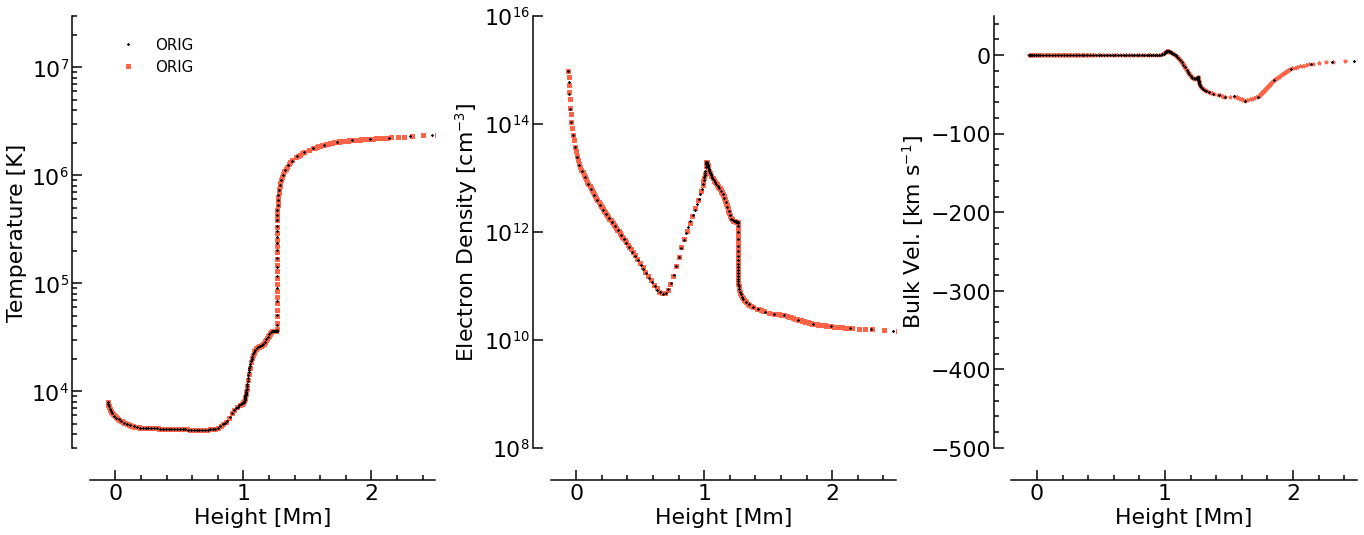

In [411]:
tind = 50

xrange = [-0.2, 2.5]
yrange_temp = [3000, 3e7]
yrange_edens = [1e8, 1e16]
yrange_vz = [-500, 50]

xtitle = 'Height [Mm]'
ytitle_temp = 'Temperature [K]'
ytitle_edens = 'Electron Density [cm$^{-3}$]'
ytitle_vz = 'Bulk Vel. [km s$^{-1}$]'

xsize = 16
ysize = 8

fig = plt.figure(figsize=(xsize, ysize))
x1 = 0.10
y1 = 0.10
dx = 0.30
dy = 0.75

sx = 0.1
sy = 0.01

ax1 = fig.add_axes([x1+0*sx+0*dx, y1+0*sy+0*dy, dx, dy])
ax2 = fig.add_axes([x1+1*sx+1*dx, y1+0*sy+0*dy, dx, dy])
ax3 = fig.add_axes([x1+2*sx+2*dx, y1+0*sy+0*dy, dx, dy])

ax1.set_xlim(xrange[0],xrange[-1])
ax1.set_ylim(yrange_temp[0],yrange_temp[-1])
ax1.set_xlabel(xtitle)
ax1.set_ylabel(ytitle_temp)

ax2.set_xlim(xrange[0],xrange[-1])
ax2.set_ylim(yrange_edens[0],yrange_edens[-1])
ax2.set_xlabel(xtitle)
ax2.set_ylabel(ytitle_edens)

ax3.set_xlim(xrange[0],xrange[-1])
ax3.set_ylim(yrange_vz[0],yrange_vz[-1])
ax3.set_xlabel(xtitle)
ax3.set_ylabel(ytitle_vz)

ax1.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax2.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax3.set_yscale('linear')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)

ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

ax2.spines['bottom'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)

ax3.spines['bottom'].set_visible(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)

 
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 

ax1.spines["bottom"].set_position(("axes",-.075))
ax1.spines["left"].set_position(("axes",-.05))
ax2.spines["bottom"].set_position(("axes",-.075))
ax2.spines["left"].set_position(("axes",-.05))
ax3.spines["bottom"].set_position(("axes",-.075))
ax3.spines["left"].set_position(("axes",-.05))



line2, = ax1.plot(z_new[tind,:]/1e8, Tg_new[tind,:],
                   linewidth = 3, linestyle = 'none', marker = 's', markersize = 4, color = 'tomato', 
                   label = 'ORIG'
                 )
line1, = ax1.plot(cdf.z1[tind,:]/1e8, cdf.tg1[tind,:],
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 2, color = 'black', 
                   label = 'ORIG'
                 )

line4, = ax2.plot(z_new[tind,:]/1e8, Ne_new[tind,:],
                   linewidth = 3, linestyle = 'none', marker = 's', markersize = 4, color = 'tomato', 
                   label = 'ORIG'
                 )
line3, = ax2.plot(cdf.z1[tind,:]/1e8, cdf.ne1[tind,:],
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 2, color = 'black', 
                   label = 'ORIG'
                 )

line6, = ax3.plot(z_new[tind,:]/1e8, vz_new[tind,:]/1e5*-1e0,
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 4, color = 'tomato', 
                   label = 'ORIG'
                 )
line5, = ax3.plot(cdf.z1[tind,:]/1e8, cdf.vz1[tind,:]/1e5*-1e0,
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 2, color = 'black', 
                   label = 'ORIG'
                 )

leg1 = ax1.legend(handles=[line1,line2],loc=(0.05, 0.85), fontsize = 15)



In [ ]:
tind = 0

xrange = [-0.2, 2.5]
yrange_edens = [1e8, 1e16]

xtitle = 'Height [Mm]'
ytitle_edens = 'Pop Density [cm$^{-3}$]'


xsize = 16
ysize = 16

fig = plt.figure(figsize=(xsize, ysize))
x1 = 0.10
y1 = 0.10
dx = 0.30
dy = 0.40

sx = 0.1
sy = 0.1

ax1 = fig.add_axes([x1+0*sx+0*dx, y1+0*sy+0*dy, dx, dy])
ax2 = fig.add_axes([x1+1*sx+1*dx, y1+0*sy+0*dy, dx, dy])
ax3 = fig.add_axes([x1+2*sx+2*dx, y1+0*sy+0*dy, dx, dy])

ax4 = fig.add_axes([x1+0*sx+0*dx, y1+1*sy+1*dy, dx, dy])
ax5 = fig.add_axes([x1+1*sx+1*dx, y1+1*sy+1*dy, dx, dy])
ax6 = fig.add_axes([x1+2*sx+2*dx, y1+1*sy+1*dy, dx, dy])


ax1.set_xlim(xrange[0],xrange[-1])
ax1.set_ylim(yrange_edens[0],yrange_edens[-1])
ax1.set_xlabel(xtitle)
ax1.set_ylabel(ytitle_temp)

ax2.set_xlim(xrange[0],xrange[-1])
ax2.set_ylim(yrange_edens[0],yrange_edens[-1])
ax2.set_xlabel(xtitle)
ax2.set_ylabel(ytitle_edens)

ax3.set_xlim(xrange[0],xrange[-1])
ax3.set_ylim(yrange_edens[0],yrange_edens[-1])
ax3.set_xlabel(xtitle)
ax3.set_ylabel(ytitle_vz)

ax4.set_xlim(xrange[0],xrange[-1])
ax4.set_ylim(yrange_edens[0],yrange_edens[-1])
ax4.set_xlabel(xtitle)
ax4.set_ylabel(ytitle_temp)

ax5.set_xlim(xrange[0],xrange[-1])
ax5.set_ylim(yrange_edens[0],yrange_edens[-1])
ax5.set_xlabel(xtitle)
ax5.set_ylabel(ytitle_edens)

ax6.set_xlim(xrange[0],xrange[-1])
ax6.set_ylim(yrange_edens[0],yrange_edens[-1])
ax6.set_xlabel(xtitle)
ax6.set_ylabel(ytitle_vz)

ax1.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax2.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax3.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax4.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax5.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)
ax6.set_yscale('log')
#     ax1.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
# ax1.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
# for label in ax1.yaxis.get_ticklabels()[::2]:
#     label.set_visible(False) #(3)

ax1.spines['bottom'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

ax2.spines['bottom'].set_visible(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)

ax3.spines['bottom'].set_visible(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(True)

ax4.spines['bottom'].set_visible(True)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(True)

ax5.spines['bottom'].set_visible(True)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(True)

ax6.spines['bottom'].set_visible(True)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['left'].set_visible(True)

 
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax5.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 
ax6.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labeltop = False,
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False,
    labelleft = True
    ) 

ax1.spines["bottom"].set_position(("axes",-.075))
ax1.spines["left"].set_position(("axes",-.05))
ax2.spines["bottom"].set_position(("axes",-.075))
ax2.spines["left"].set_position(("axes",-.05))
ax3.spines["bottom"].set_position(("axes",-.075))
ax3.spines["left"].set_position(("axes",-.05))
ax4.spines["bottom"].set_position(("axes",-.075))
ax4.spines["left"].set_position(("axes",-.05))
ax5.spines["bottom"].set_position(("axes",-.075))
ax5.spines["left"].set_position(("axes",-.05))
ax6.spines["bottom"].set_position(("axes",-.075))
ax6.spines["left"].set_position(("axes",-.05))



line2, = ax1.plot(z_new[tind,:]/1e8, HePop_new[tind,:,0],
                   linewidth = 3, linestyle = 'none', marker = 's', markersize = 4, color = 'tomato', 
                   label = 'ORIG'
                 )
line1, = ax1.plot(cdf.z1[tind,:]/1e8, hydrogen_populations[tind,:,0],
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 2, color = 'black', 
                   label = 'ORIG'
                 )

line4, = ax2.plot(z_new[tind,:]/1e8, HePop_new[tind,:,1],
                   linewidth = 3, linestyle = 'none', marker = 's', markersize = 4, color = 'tomato', 
                   label = 'ORIG'
                 )
line3, = ax2.plot(cdf.z1[tind,:]/1e8, hydrogen_populations[tind,:,1],
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 2, color = 'black', 
                   label = 'ORIG'
                 )

line6, = ax3.plot(z_new[tind,:]/1e8, HePop_new[tind,:,2],
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 4, color = 'tomato', 
                   label = 'ORIG'
                 )
line5, = ax3.plot(cdf.z1[tind,:]/1e8, hydrogen_populations[tind,:,2],
                   linewidth = 3, linestyle = 'none', marker = '*', markersize = 2, color = 'black', 
                   label = 'ORIG'
                 )

leg1 = ax1.legend(handles=[line1,line2],loc=(0.05, 0.85), fontsize = 15)




---
### <b style="color:blue"> Prepare the arrays to be written </b>



In [169]:
if depth_refine == False:
        
    z = copy.deepcopy(cdf.z1)*cm_to_m
    temperature = copy.deepcopy(cdf.tg1)
    velocity_z = copy.deepcopy(cdf.vz1)*cm_to_m
    electron_density = copy.deepcopy(cdf.ne1)*cm_to_m**(-3.0)
    H_pops = copy.deepcopy(hydrogen_populations)*cm_to_m**(-3.0)
    if include_capops == True:
        Ca_pops = copy.deepcopy(calcium_populations)*cm_to_m**(-3.0)
    if include_hepops == True:
        He_pops = copy.deepcopy(helium_populations)*cm_to_m**(-3.0)
    if include_hecnt == True:
        He_Cnt = copy.deepcopy(helium_cnt)
        
    nx = len(cdf.time)
    ny = 1
    nz = (z.shape)[1]
    nsnap = 1
    nhydr = nlevh
    
elif depth_refine == True:
    
    z = copy.deepcopy(z_new)*cm_to_m
    temperature = copy.deepcopy(Tg_new)
    velocity_z = copy.deepcopy(vz_new)*cm_to_m
    electron_density = copy.deepcopy(Ne_new)*cm_to_m**(-3.0)
    H_pops = copy.deepcopy(HPop_new)*cm_to_m**(-3.0)
    if include_capops == True:
        Ca_pops = copy.deepcopy(CaPop_new)*cm_to_m**(-3.0)
    if include_hepops == True:
        He_pops = copy.deepcopy(HePop_new)*cm_to_m**(-3.0)
    if include_hecnt == True:
        He_Cnt = copy.deepcopy(HeCnt_new)
        
    nx = len(cdf.time)
    ny = 1
    nz = (z.shape)[1]
    nsnap = 1
    nhydr = nlevh